What are the temporal patterns of phoneme prediction performance for a model?

In [132]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [133]:
import datasets
import torch
import transformers
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [134]:
test_dataset_path = "../out/rnn/rnn0_hidden768_drop6/test_result"
test_dataset = datasets.load_from_disk(test_dataset_path)

In [135]:
tokenizer = transformers.Wav2Vec2Tokenizer.from_pretrained("charsiu/tokenizer_en_cmu")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/userdata/jgauthier/transformers/lib/python3.10/site-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:792: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [136]:
analysis_key = "phonemic_detail"

In [137]:
playground = test_dataset.select(range(100))

In [138]:
phoneme_vocab = tokenizer.get_vocab()
max_track_width = 30
prediction_results = []

for item in playground:
    num_frames = item["real_frames"]
    compression_ratio = item["compression_ratio"]

    # For every frame, track which phoneme has span over that frame.
    # TODO could be multiple
    phoneme_span = np.ones(num_frames, dtype=int) * -1
    # track the count of phonemes seen so far within each frame
    phoneme_index = np.ones(num_frames, dtype=int) * -1
    for i, (start, stop, phoneme) in enumerate(zip(item[analysis_key]["start"], item[analysis_key]["stop"], item[analysis_key]["utterance"])):
        start = int(start * compression_ratio)
        stop = int(stop * compression_ratio)
        phoneme_span[start:stop] = phoneme_vocab[phoneme]
        phoneme_index[start:stop] = i
    # track the index of the word spanning each frame
    word_span = np.ones(num_frames, dtype=int) * -1
    for i, (start, stop) in enumerate(zip(item["word_detail"]["start"], item["word_detail"]["stop"])):
        start = int(start * compression_ratio)
        stop = int(stop * compression_ratio)
        word_span[start:stop] = i

    item_id = f"{item['speaker_id']}/{item['id']}"
    predicted = np.array(item["predicted"])

    for i in range(num_frames):
        if phoneme_index[i] == -1:
            continue
        if word_span[i] == -1:
            continue

        for j in range(max(0, i - max_track_width), min(num_frames, i + max_track_width)):
            if phoneme_index[j] == -1:
                continue
            phoneme_j = phoneme_span[j]
            if phoneme_j == -1:
                continue
            if word_span[j] == -1:
                continue

            prediction_results.append({
                "item_id": item_id,
                "frame_id": i,
                "target_frame_id": j,
                "prediction": predicted[i, phoneme_j],
                "distance_frames": i - j,
                "distance_phonemes": phoneme_index[i] - phoneme_index[j],
                "distance_words": word_span[i] - word_span[j],
            })

In [143]:
frame_results_df = pd.DataFrame(prediction_results)
frame_results_df["same_word"] = frame_results_df["distance_words"] == 0
frame_results_df["same_phoneme"] = frame_results_df["distance_phonemes"] == 0
frame_results_df

,item_id,frame_id,target_frame_id,prediction,distance_frames,distance_phonemes,distance_words,same_word,same_phoneme
0,AKS0/SA1,30,30,1,0,0,0,True,True
1,AKS0/SA1,30,31,1,-1,0,0,True,True
2,AKS0/SA1,30,32,1,-2,0,0,True,True
3,AKS0/SA1,30,33,1,-3,0,0,True,True
4,AKS0/SA1,30,34,1,-4,0,0,True,True
...,...,...,...,...,...,...,...,...,...
688753,STK0/SX394,118,114,1,4,1,0,True,False
688754,STK0/SX394,118,115,1,3,1,0,True,False
688755,STK0/SX394,118,116,1,2,1,0,True,False
688756,STK0/SX394,118,117,1,1,0,0,True,True


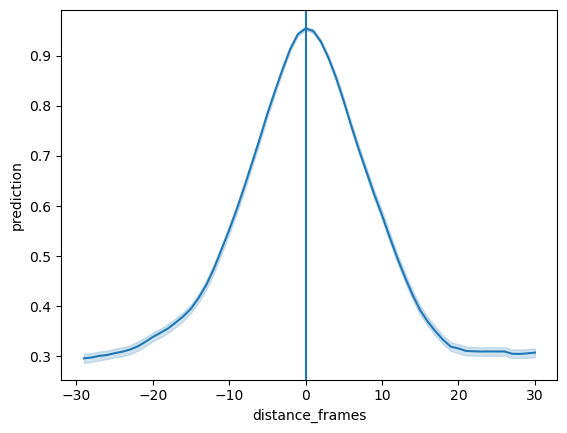

In [140]:
ax = sns.lineplot(data=frame_results_df, x="distance_frames", y="prediction")
ax.axvline(0)

<Axes: xlabel='distance_phonemes', ylabel='prediction'>

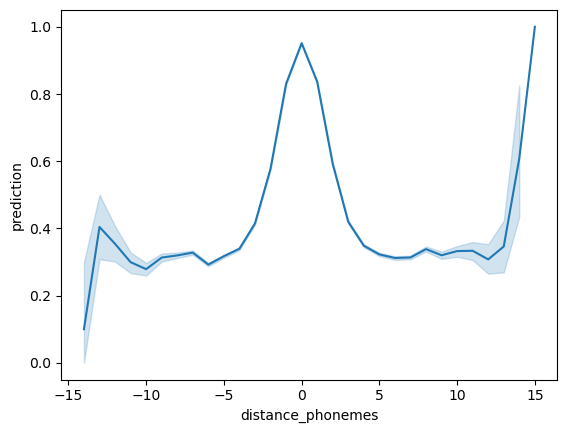

In [141]:
sns.lineplot(data=frame_results_df, x="distance_phonemes", y="prediction")

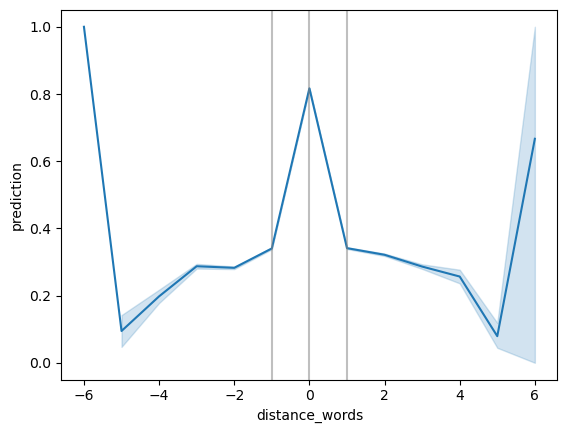

In [142]:
ax = sns.lineplot(data=frame_results_df, x="distance_words", y="prediction")
ax.axvline(0, color="gray", alpha=0.5)
ax.axvline(-1, color="gray", alpha=0.5)
ax.axvline(1, color="gray", alpha=0.5)

<Axes: xlabel='same_word', ylabel='prediction'>

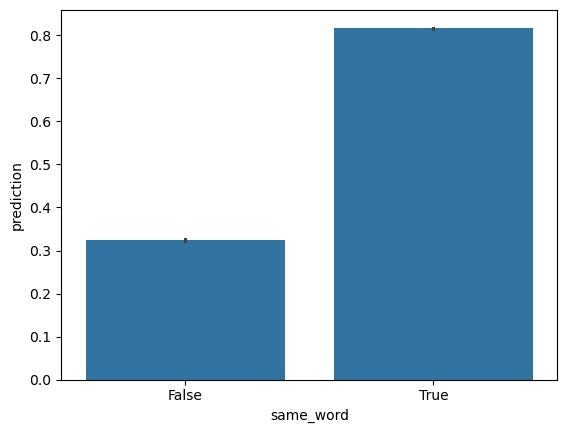

In [144]:
sns.barplot(data=frame_results_df, x="same_word", y="prediction")

<Axes: xlabel='same_phoneme', ylabel='prediction'>

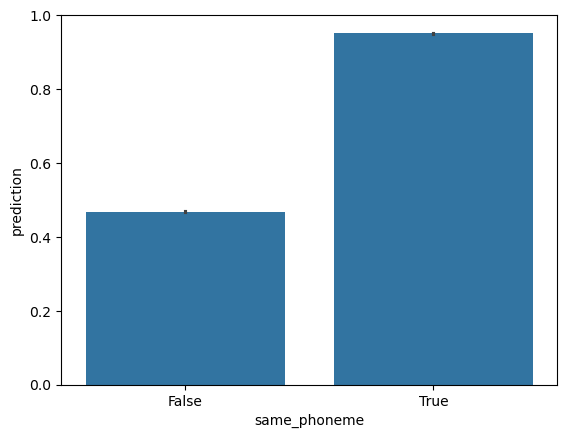

In [145]:
sns.barplot(data=frame_results_df, x="same_phoneme", y="prediction")